[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WarrenTseng/monai_endoscopy_tutorial/blob/main/MONAIGenAI/MONAI_GenAI_Endoscopy_DDPM_colab.ipynb)

## Environment Preparation

In [ ]:
!pip install monai[tqdm]

In [ ]:
!git clone https://github.com/Project-MONAI/GenerativeModels.git

In [ ]:
%cd GenerativeModels/
!python setup.py install

## Setup imports

In [ ]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks import nets
from generative.networks.schedulers import DDPMScheduler

## Prepare Kvasir-SEG Dataset

In [ ]:
set_determinism(42)

!wget https://datasets.simula.no/downloads/kvasir-seg.zip
!unzip kvasir-seg.zip

In [ ]:
path_img = './Kvasir-SEG/images/'
path_msk = './Kvasir-SEG/masks/'
fnames_img = [f for f in os.listdir(path_img) if '.jpg' in f]
datalist = []
for fname in fnames_img:
    data = {'image': path_img+fname, 'seg': path_msk+fname}
    datalist.append(data)

# Shuffle
np.random.shuffle(datalist)
# Split the datalist to train and validation
train_datalist = datalist[:800]
val_datalist = datalist[800:]
datalist[:3]

## Transforms and Dataloader Setup 

In [ ]:
batch_size = 1
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys=["image"], spatial_size=[256, 256]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys=["image"], spatial_size=[256, 256]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

## Training Data Preview

In [ ]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = check_data["image"][0].numpy()
plt.figure("training images", (3, 3))
plt.imshow(image_visualisation.transpose([2, 1, 0]), vmin=0, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

## Define model, DDPM Scheduler and Inferer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nets.DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
#     num_channels=(256, 512, 512, 1024),
#     attention_levels=(False, True, True, True),
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
#     num_head_channels=512,
    num_head_channels=256,
    norm_num_groups=32,
)
model.to(device)

num_train_timesteps=1000
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
DDPMScheduler()
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

inferer = DiffusionInferer(scheduler)

## Training

In [ ]:
n_epochs = 50
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

# setting for Auto Mixed Precision (AMP)
scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch+1}")
    ## Training ##
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        # setting for Auto Mixed Precision (AMP)
        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    ## Validation ##
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1,)+tuple(images[0].shape))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0].cpu().numpy().transpose([2,1,0]), vmin=0, vmax=1)
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## DDPM Visualization

100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s]

2023-04-21 09:40:03,510 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


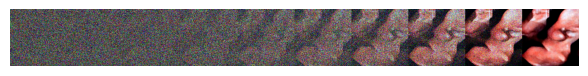

In [13]:
def ddpm_vis():
    model.eval()
    noise = torch.randn((1, 3, 256, 256))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
    with autocast(enabled=True):
        image, intermediates = inferer.sample(
            input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=num_train_timesteps//10
        )

    chain = torch.cat(intermediates, dim=-1)

    plt.style.use("default")
    plt.imshow(chain[0].cpu().numpy().transpose([1,2,0]), vmin=0, vmax=1)
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    return chain

_ = ddpm_vis()